    ImageId  ClassType                                    MultipolygonWKT
0  6040_2_2          1                                 MULTIPOLYGON EMPTY
1  6040_2_2          2                                 MULTIPOLYGON EMPTY
2  6040_2_2          3                                 MULTIPOLYGON EMPTY
3  6040_2_2          4  MULTIPOLYGON (((0.003025 -0.007879000000000001...
4  6040_2_2          5  MULTIPOLYGON (((0.005311 -0.009044999999999999...
    ImageId      Xmax     Ymin
0  6120_2_4  0.009180 -0.00904
1  6120_2_3  0.009169 -0.00904
2  6120_2_2  0.009188 -0.00904
3  6120_2_1  0.009188 -0.00904
4  6120_2_0  0.009188 -0.00904
ImageId : 6040_2_2
1 : Bldg 	count = 0
2 : Struct 	count = 0
3 : Road 	count = 0
4 : Track 	count = 2
5 : Trees 	count = 3879
6 : Crops 	count = 0
7 : Fast H20 	count = 0
8 : Slow H20 	count = 0
9 : Truck 	count = 0
10 : Car 	count = 0
ImageId : 6040_2_2
1 : Bldg 	count = 0
2 : Struct 	count = 0
3 : Road 	count = 0
4 : Track 	count = 2
5 : Trees 	count = 3879
6 : Crop

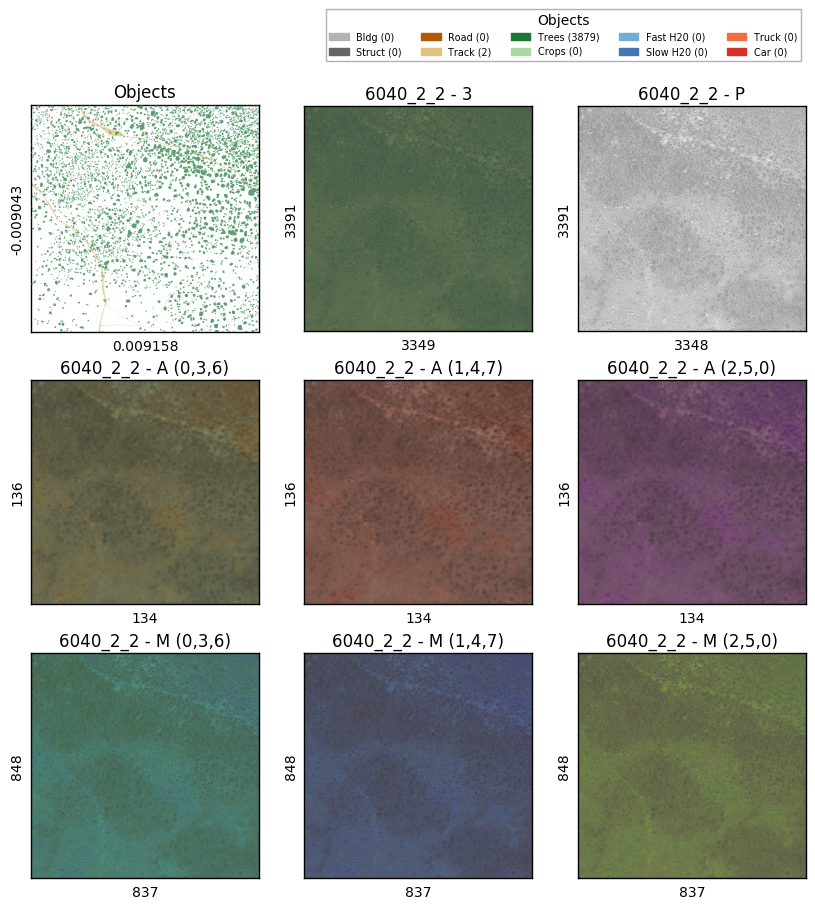

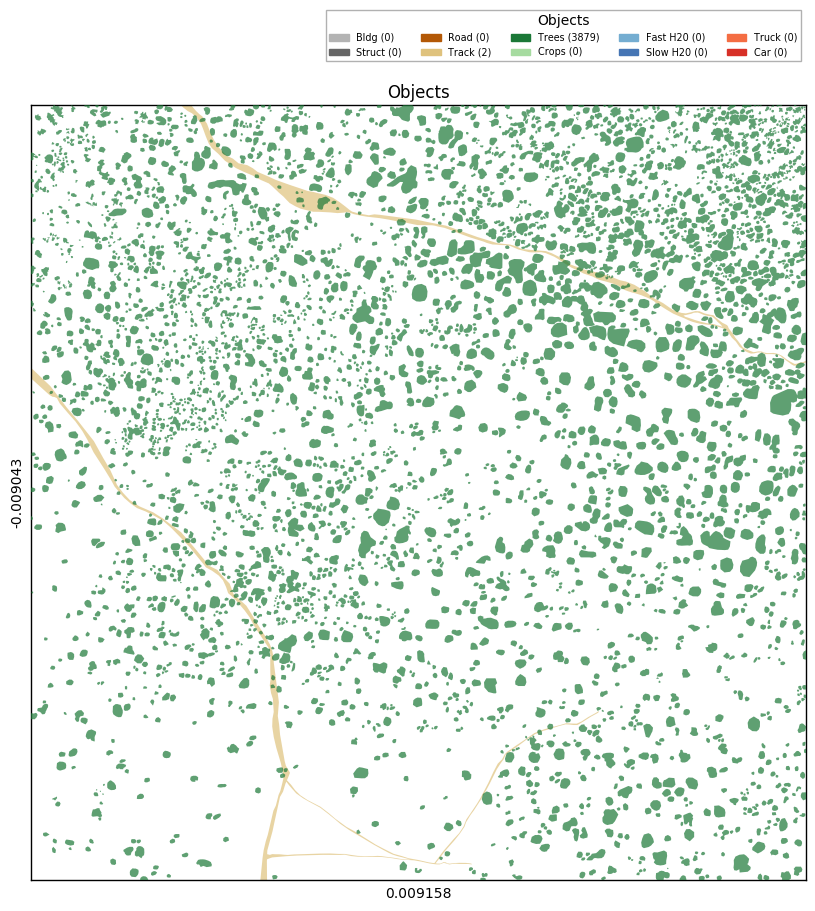

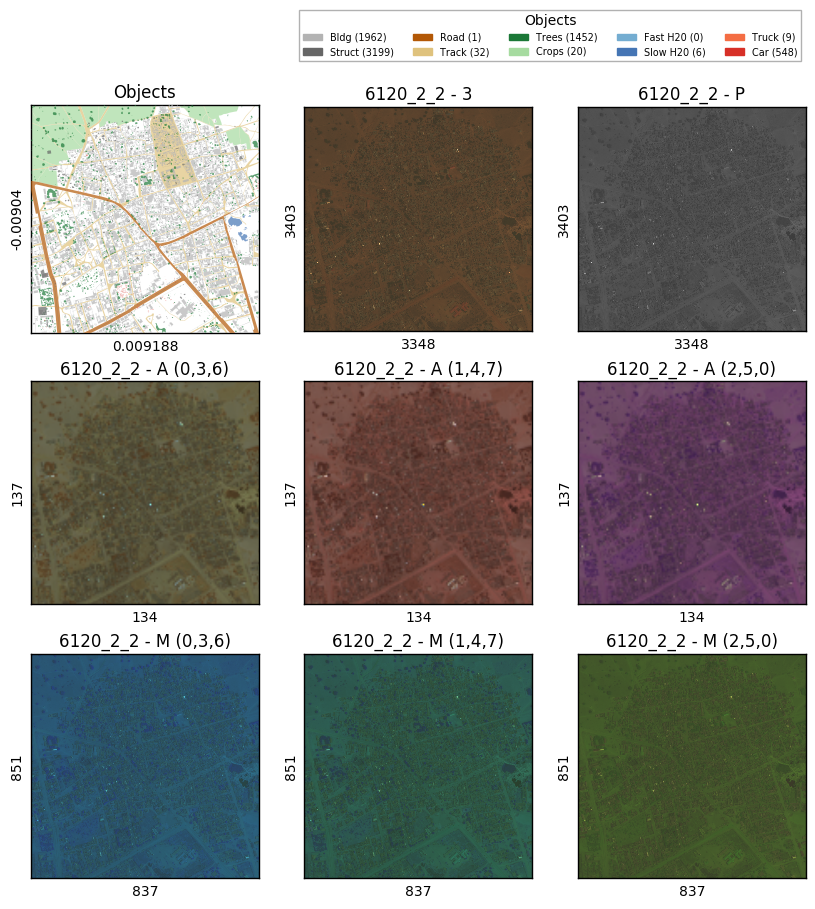

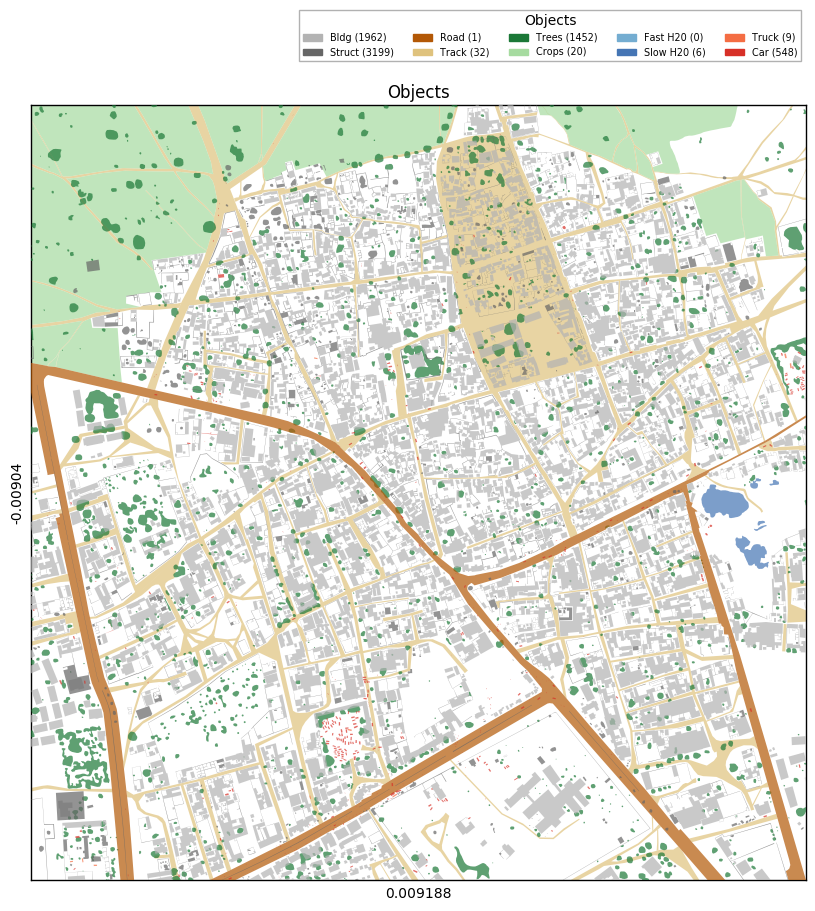

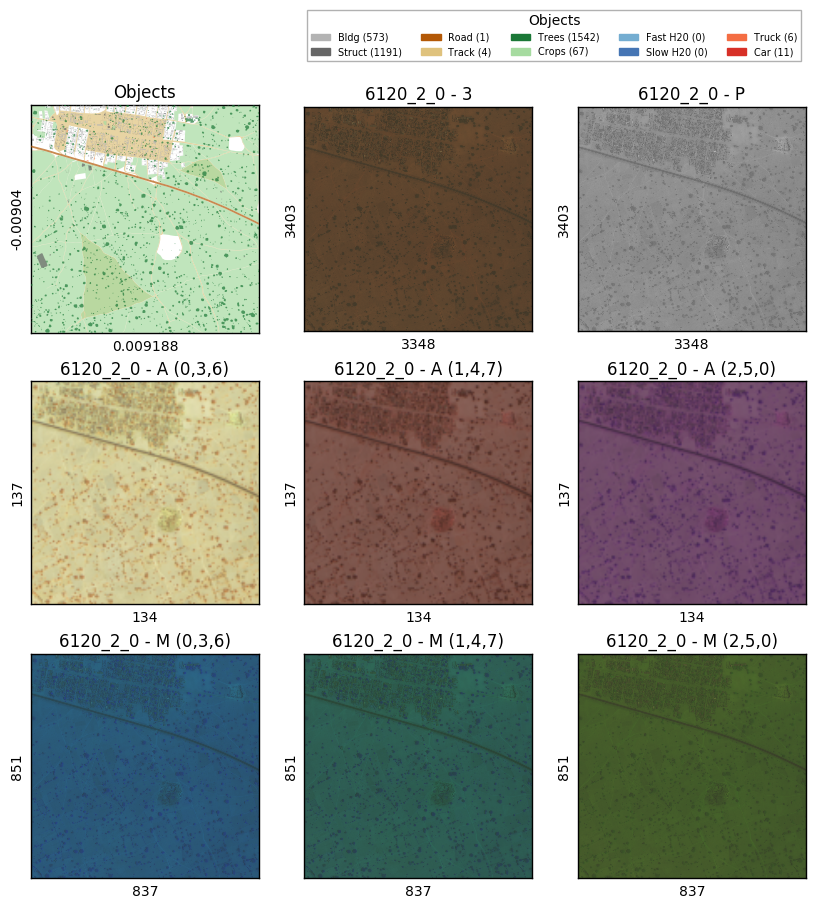

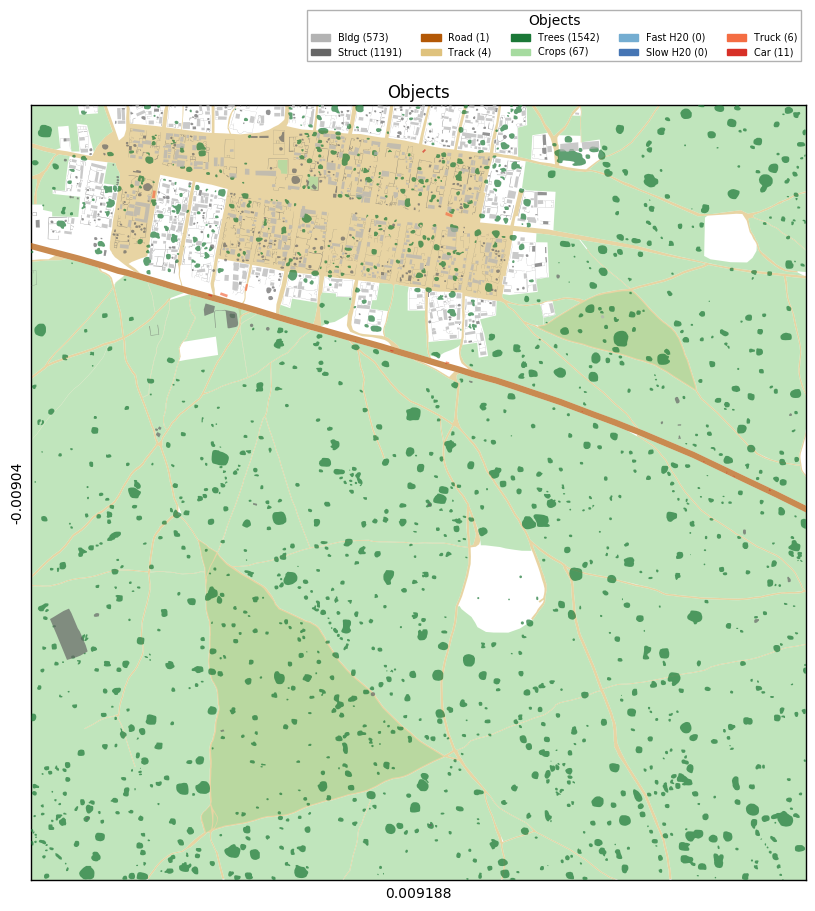

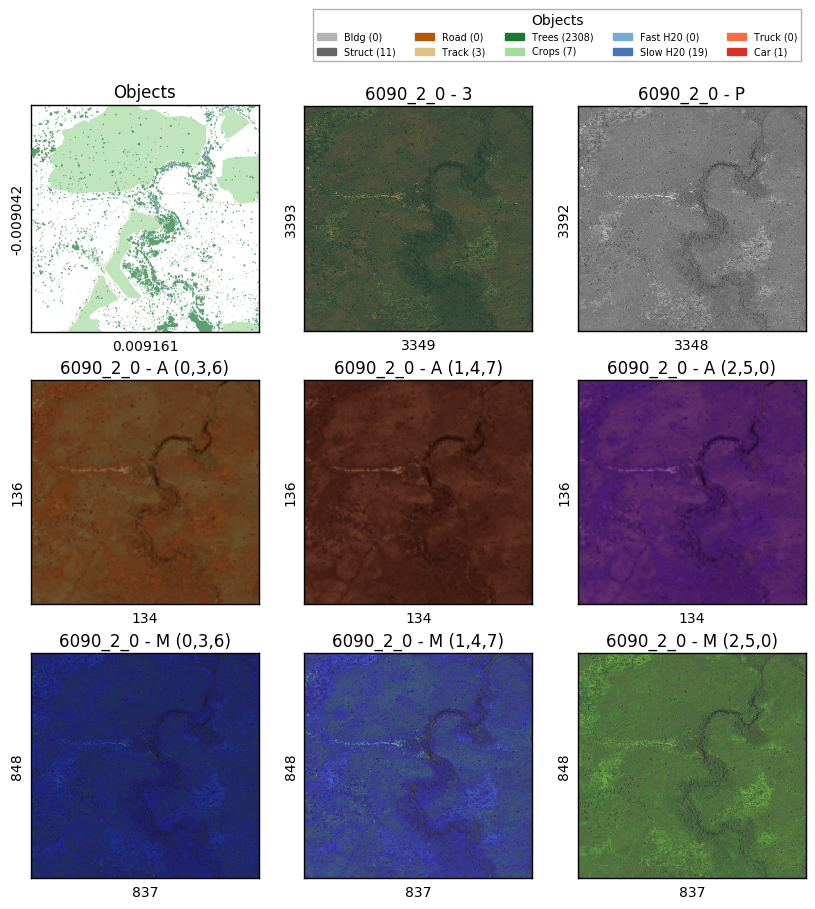

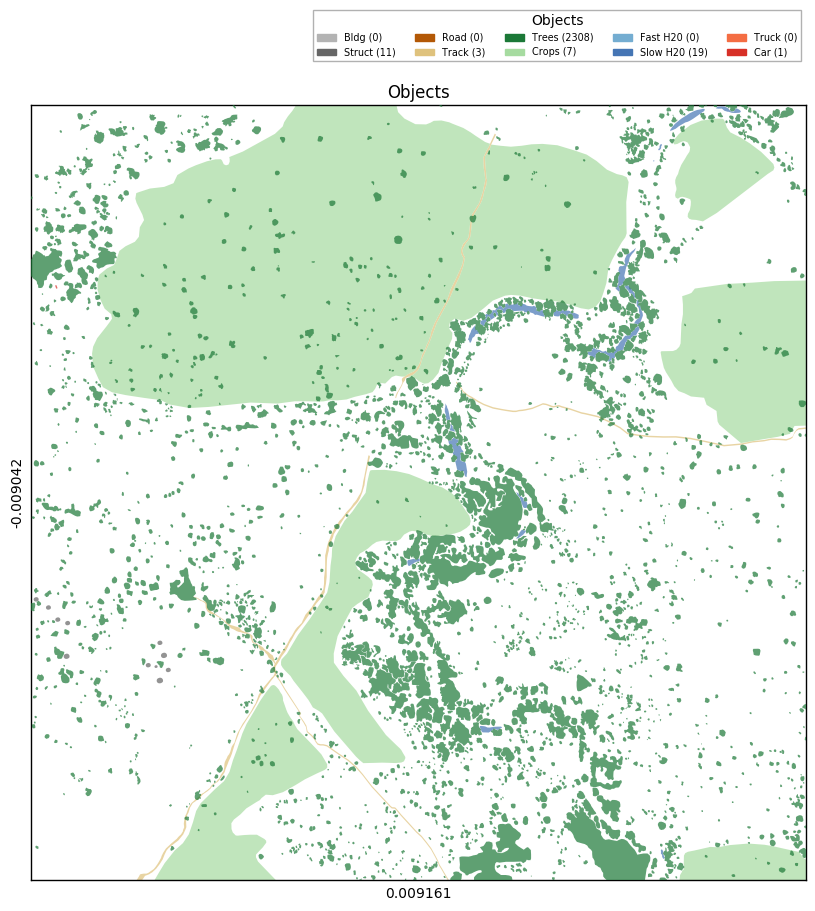

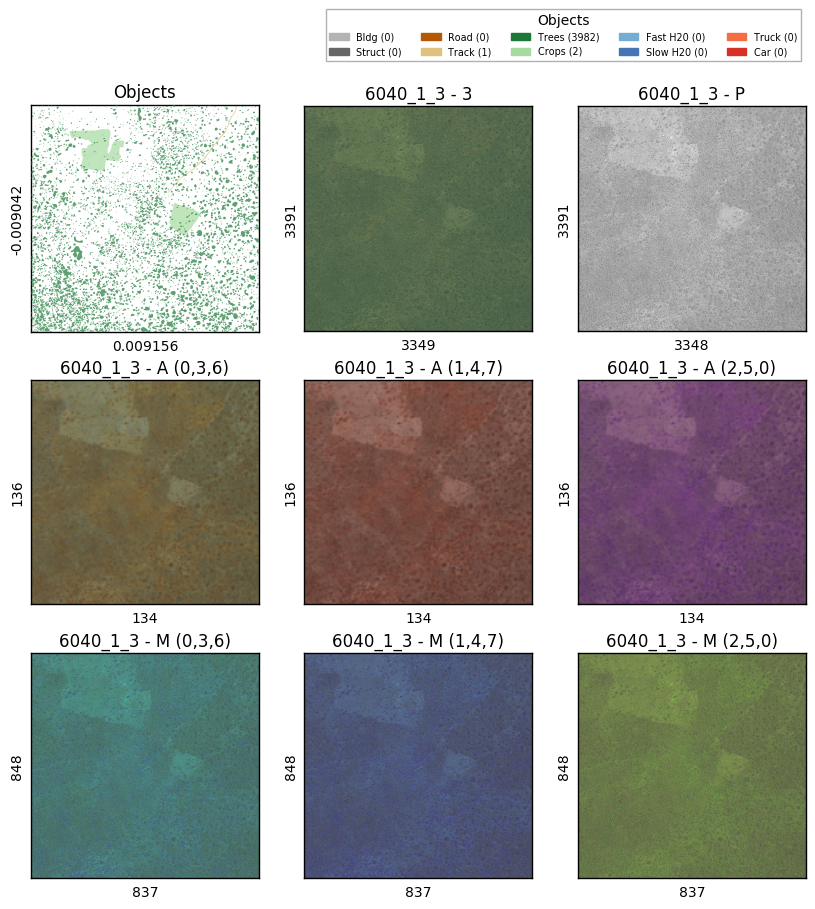

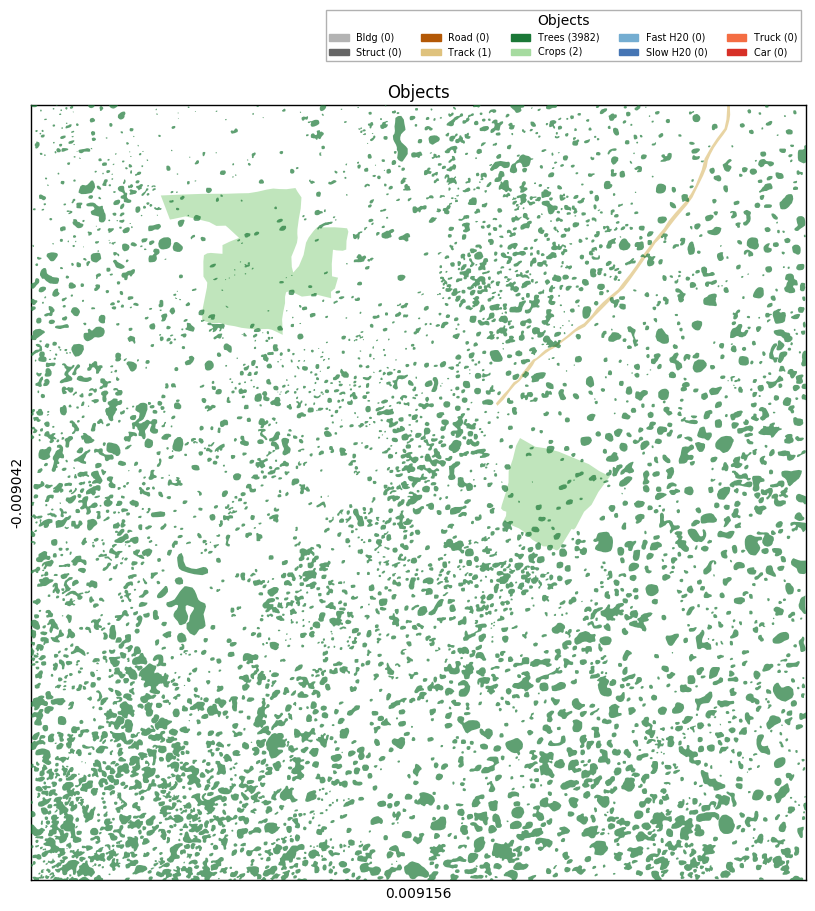

In [15]:
"""
Author : amanbh

- Set up some basic functions to load/manipulate image data
- Visualize/Summarize cType counts, training data, and true classes
- Plot Polygons with holes correctly by using descartes package

Based on Kernel by
    Author : Oleg Medvedev
    Link   : https://www.kaggle.com/torrinos/dstl-satellite-imagery-feature-detection/exploration-and-plotting/run/553107
"""

import pandas as pd
import numpy as np

from shapely.wkt import loads as wkt_loads
from matplotlib.patches import Polygon, Patch

# decartes package makes plotting with holes much easier
from descartes.patch import PolygonPatch

import matplotlib.pyplot as plt
import tifffile as tiff

import pylab
# turn interactive mode on so that plots immediately
# See: http://stackoverflow.com/questions/2130913/no-plot-window-in-matplotlib
# pylab.ion()

inDir = './input'

# Give short names, sensible colors and zorders to object types
CLASSES = {
        1 : 'Bldg',
        2 : 'Struct',
        3 : 'Road',
        4 : 'Track',
        5 : 'Trees',
        6 : 'Crops',
        7 : 'Fast H20',
        8 : 'Slow H20',
        9 : 'Truck',
        10 : 'Car',
        }
COLORS = {
        1 : '0.7',
        2 : '0.4',
        3 : '#b35806',
        4 : '#dfc27d',
        5 : '#1b7837',
        6 : '#a6dba0',
        7 : '#74add1',
        8 : '#4575b4',
        9 : '#f46d43',
        10: '#d73027',
        }
ZORDER = {
        1 : 5,
        2 : 5,
        3 : 4,
        4 : 1,
        5 : 3,
        6 : 2,
        7 : 7,
        8 : 8,
        9 : 9,
        10: 10,
        }

# read the training data from train_wkt_v2.csv
df = pd.read_csv(inDir + '/train_wkt_v3.csv')
print(df.head())

# grid size will also be needed later..
gs = pd.read_csv(inDir + '/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
print(gs.head())

# imageIds in a DataFrame
allImageIds = gs.ImageId.unique()
trainImageIds = df.ImageId.unique()


def get_image_names(imageId):
    '''
    Get the names of the tiff files
    '''
    d = {'3': '{}/three_band/{}.tif'.format(inDir, imageId),
         'A': '{}/sixteen_band/{}_A.tif'.format(inDir, imageId),
         'M': '{}/sixteen_band/{}_M.tif'.format(inDir, imageId),
         'P': '{}/sixteen_band/{}_P.tif'.format(inDir, imageId),
         }
    return d


def get_images(imageId, img_key = None):
    '''
    Load images correspoding to imageId

    Parameters
    ----------
    imageId : str
        imageId as used in grid_size.csv
    img_key : {None, '3', 'A', 'M', 'P'}, optional
        Specify this to load single image
        None loads all images and returns in a dict
        '3' loads image from three_band/
        'A' loads '_A' image from sixteen_band/
        'M' loads '_M' image from sixteen_band/
        'P' loads '_P' image from sixteen_band/

    Returns
    -------
    images : dict
        A dict of image data from TIFF files as numpy array
    '''
    img_names = get_image_names(imageId)
    images = dict()
    if img_key is None:
        for k in img_names.keys():
            images[k] = tiff.imread(img_names[k])
    else:
        images[img_key] = tiff.imread(img_names[img_key])
    return images


def get_size(imageId):
    """
    Get the grid size of the image

    Parameters
    ----------
    imageId : str
        imageId as used in grid_size.csv
    """
    xmax, ymin = gs[gs.ImageId == imageId].iloc[0,1:].astype(float)
    W, H = get_images(imageId, '3')['3'].shape[1:]
    return (xmax, ymin, W, H)


def is_training_image(imageId):
    '''
    Returns
    -------
    is_training_image : bool
        True if imageId belongs to training data
    '''
    return any(trainImageIds == imageId)


def plot_polygons(fig, ax, polygonsList):
    '''
    Plot descrates.PolygonPatch from list of polygons objs for each CLASS
    '''
    legend_patches = []
    for cType in polygonsList:
        print('{} : {} \tcount = {}'.format(cType, CLASSES[cType], len(polygonsList[cType])))
        legend_patches.append(Patch(color=COLORS[cType],
                                    label='{} ({})'.format(CLASSES[cType], len(polygonsList[cType]))))
        for polygon in polygonsList[cType]:
            mpl_poly = PolygonPatch(polygon,
                                    color=COLORS[cType],
                                    lw=0,
                                    alpha=0.7,
                                    zorder=ZORDER[cType])
            ax.add_patch(mpl_poly)
    # ax.relim()
    ax.autoscale_view()
    ax.set_title('Objects')
    ax.set_xticks([])
    ax.set_yticks([])
    return legend_patches


def plot_image(fig, ax, imageId, img_key, selected_channels=None):
    '''
    Plot get_images(imageId)[image_key] on axis/fig
    Optional: select which channels of the image are used (used for sixteen_band/ images)
    Parameters
    ----------
    img_key : str, {'3', 'P', 'N', 'A'}
        See get_images for description.
    '''
    images = get_images(imageId, img_key)
    img = images[img_key]
    title_suffix = ''
    if selected_channels is not None:
        img = img[selected_channels]
        title_suffix = ' (' + ','.join([ repr(i) for i in selected_channels ]) + ')'
    if len(img.shape) == 2:
        new_img = np.zeros((3, img.shape[0], img.shape[1]))
        new_img[0] = img
        new_img[1] = img
        new_img[2] = img
        img = new_img
    
    tiff.imshow(img, figure=fig, subplot=ax)
    ax.set_title(imageId + ' - ' + img_key + title_suffix)
    ax.set_xlabel(img.shape[-2])
    ax.set_ylabel(img.shape[-1])
    ax.set_xticks([])
    ax.set_yticks([])



def visualize_image(imageId, plot_all=True):
    '''         
    Plot all images and object-polygons
    
    Parameters
    ----------
    imageId : str
        imageId as used in grid_size.csv
    plot_all : bool, True by default
        If True, plots all images (from three_band/ and sixteen_band/) as subplots.
        Otherwise, only plots Polygons.
    '''         
    df_image = df[df.ImageId == imageId]
    xmax, ymin, W, H = get_size(imageId)
    
    if plot_all:
        fig, axArr = plt.subplots(figsize=(10, 10), nrows=3, ncols=3)
        ax = axArr[0][0]
    else:
        fig, axArr = plt.subplots(figsize=(10, 10))
        ax = axArr
    if is_training_image(imageId):
        print('ImageId : {}'.format(imageId))
        polygonsList = {}
        for cType in CLASSES.keys():
            polygonsList[cType] = wkt_loads(df_image[df_image.ClassType == cType].MultipolygonWKT.values[0])
        legend_patches = plot_polygons(fig, ax, polygonsList)
        ax.set_xlim(0, xmax)
        ax.set_ylim(ymin, 0)
        ax.set_xlabel(xmax)
        ax.set_ylabel(ymin)
    if plot_all:
        plot_image(fig, axArr[0][1], imageId, '3')
        plot_image(fig, axArr[0][2], imageId, 'P')
        plot_image(fig, axArr[1][0], imageId, 'A', [0, 3, 6])
        plot_image(fig, axArr[1][1], imageId, 'A', [1, 4, 7])
        plot_image(fig, axArr[1][2], imageId, 'A', [2, 5, 0])
        plot_image(fig, axArr[2][0], imageId, 'M', [0, 3, 6])
        plot_image(fig, axArr[2][1], imageId, 'M', [1, 4, 7])
        plot_image(fig, axArr[2][2], imageId, 'M', [2, 5, 0])

    if is_training_image(imageId):
        ax.legend(handles=legend_patches,
                   # loc='upper center',
                   bbox_to_anchor=(0.9, 1),
                   bbox_transform=plt.gcf().transFigure,
                   ncol=5,
                   fontsize='x-small',
                   title='Objects',
                   # mode="expand",
                   framealpha=0.3)
    return (fig, axArr, ax)

# Loop over few training images and save to files
for imageId in trainImageIds[:5]:
    fig, axArr, ax = visualize_image(imageId, plot_all=True)
    plt.savefig('./All--' + imageId + '.pdf')
    fig, axArr, ax = visualize_image(imageId, plot_all=False)
    plt.savefig('./Objects--' + imageId + '.pdf')


# Optionally, view images immediately:
# pylab.show()
# Uncomment to show plot when interactive mode is off 
# (this function blocks till fig is closed)